# **IMPLEMENTASI DAN EKSPERIMEN ALGORITMA SELF ORGANIZING MAP (SOM) UNTUK KLASTERING DAN KLASIFIKASI PADA TIGA DATASET**

Nama  : Muhammad Figo Razzan Fadillah

NRP   : 152022064

Kelas : IFB-454 DEEP LEARNING  

## Konteks Proyek Kelompok:
Notebook ini merupakan bagian dari proyek kelompok dengan tiga anggota yang masing-masing menguji arsitektur deep learning berbeda. Fokus notebook ini adalah implementasi dan evaluasi algoritma SOM pada tiga dataset yang sama.

## Tujuan Eksperimen:
Menguji dan mencari konfigurasi terbaik dari algoritma SOM untuk klastering pada ketiga dataset. Menganalisis faktor yang berkontribusi pada performa terbaik tiap dataset.

## Dataset yang Digunakan:
1. **BBC News**  
   - Jenis: Teks (berita)  
   - Tujuan: Clustering dokumen berita berdasarkan topik  

2. **Sentiment140**  
   - Jenis: Teks (tweet)  
   - Tujuan: Clustering tweet untuk analisis sentimen dan pola teks  

3. **FordA (UCR Time Series Classification Archive)**  
   - Jenis: Time Series  
   - Tujuan: Clustering pola sinyal time series  

## Rencana Implementasi:
- Import library yang diperlukan  
- Memuat dan eksplorasi dataset  
- Preprocessing data sesuai kebutuhan SOM  
- Mendefinisikan dan melatih model SOM dengan parameter yang bervariasi  
- Evaluasi performa model menggunakan metrik klasifikasi dan klastering  
- Visualisasi hasil dan peta SOM  

## Output yang Dihasilkan:
- Source code implementasi SOM  
- Metrik evaluasi dan hasil klastering/klasifikasi  
- Penjelasan model dan parameter yang optimal  
- Data pendukung untuk laporan kelompok terkait performa arsitektur SOM  


# **Tahap 1 - Import Semua Library**
  Semua library yang dibutuhkan diimpor pada tahap awal untuk menjaga keteraturan kode.

In [1]:
# === Install Library Tambahan ===
!pip install minisom

# === Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === Data Handling ===
import os
import pandas as pd
import numpy as np

# === Text Preprocessing ===
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# === Scaling & Machine Learning ===
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

# === SOM ===
from minisom import MiniSom

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Warnings ===
import warnings
warnings.filterwarnings("ignore")

# === NLTK Downloads ===
nltk.download('punkt_tab')
nltk.download('stopwords')


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=71a597b7e5a5360976872bbee62e6682df59929e55e505e0571ac1fb9d84e3da
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom
Mounted at /content/drive


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Tahap 2 – Load Dataset**
Pada tahap ini, ketiga dataset yang akan digunakan dimuat ke dalam notebook sesuai format dan struktur masing-masing. Proses pemuatan dilakukan sebagai berikut:

- **Tahap 2.1:** Load dataset **BBC News** dari folder per kategori, setiap file teks dibaca dan label diambil dari nama folder kategori. Data disimpan dalam DataFrame dengan kolom `text` dan `label`.
- **Tahap 2.2:** Load dataset **FordA** (UCR format) dengan fungsi khusus untuk membaca file .txt, memisahkan label dan data time series, lalu menggabungkan data train dan test menjadi satu array.
- **Tahap 2.3:** Load dataset **Sentiment140** dari file CSV, membaca seluruh data tweet dan kolom target, lalu menyimpan ke DataFrame dengan nama kolom yang sesuai.

Setelah semua dataset berhasil dimuat, dilakukan eksplorasi awal dengan menampilkan jumlah data dan contoh isi data dari masing-masing dataset.

In [2]:
# === Set root path dari Google Drive ===
base_path = '/content/drive/MyDrive/DL-MultiArchitecture-Experiment/dataset/'

# === Load BBC News Dataset ===
bbc_root_path = os.path.join(base_path, 'BBCNews')
bbc_texts = []
bbc_labels = []

for category in os.listdir(bbc_root_path):
    category_path = os.path.join(bbc_root_path, category)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            if filename.endswith('.txt'):
                with open(os.path.join(category_path, filename), 'r', encoding='latin-1') as f:
                    content = f.read()
                    bbc_texts.append(content)
                    bbc_labels.append(category)

df_bbc = pd.DataFrame({'text': bbc_texts, 'label': bbc_labels})
print(f"[BBC] Loaded {len(df_bbc)} documents.")

# === Load FordA Dataset (UCR format .txt) ===
def load_ucr_ts(file_path):
    data = []
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            values = line.strip().split()
            labels.append(int(float(values[0])))
            ts = list(map(float, values[1:]))
            data.append(ts)
    return np.array(data), np.array(labels)

forda_train_path = os.path.join(base_path, 'FordA/FordA_TRAIN.txt')
forda_test_path = os.path.join(base_path, 'FordA/FordA_TEST.txt')

X_train_forda, y_train_forda = load_ucr_ts(forda_train_path)
X_test_forda, y_test_forda = load_ucr_ts(forda_test_path)

X_forda = np.vstack((X_train_forda, X_test_forda))
y_forda = np.concatenate((y_train_forda, y_test_forda))
print(f"[FordA] Loaded {X_forda.shape[0]} samples with {X_forda.shape[1]} time steps.")

# === Load Sentiment140 Dataset ===
sent140_path = os.path.join(base_path, 'Sentimen140/training.1600000.processed.noemoticon.csv')
df_sent = pd.read_csv(sent140_path, encoding='latin-1', header=None)
df_sent.columns = ['target', 'id', 'date', 'query', 'user', 'text']
print(f"[Sentiment140] Loaded {len(df_sent)} tweets.")

# Preview sample
print("\n[BBC sample]")
print(df_bbc.head(1))

print("\n[FordA sample]")
print("Label:", y_forda[0])
print("Time series:", X_forda[0][:10], "...")

print("\n[Sentiment140 sample]")
print(df_sent[['target', 'text']].head(1))


[BBC] Loaded 2225 documents.
[FordA] Loaded 4921 samples with 500 time steps.
[Sentiment140] Loaded 1600000 tweets.

[BBC sample]
                                                text label
0  Sony PSP tipped as a 'must-have'\n\nSony's Pla...  tech

[FordA sample]
Label: -1
Time series: [-0.79717168 -0.66439208 -0.37301463  0.04081512  0.52693599  0.98428794
  1.3531202   1.5781078   1.6592509   1.6408093 ] ...

[Sentiment140 sample]
   target                                               text
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...


# **Tahap 3 – Preprocessing Dataset**

Pada tahap ini, dilakukan preprocessing pada masing-masing dataset agar data siap digunakan untuk pelatihan dan evaluasi model SOM. Setiap dataset diproses sesuai karakteristiknya:

---

## 📝 **Teks (BBC News & Sentiment140)**

- Teks dibersihkan menggunakan fungsi `clean_text`, yang terdiri dari beberapa tahap penting:
  - Mengubah semua huruf menjadi **lowercase**.
  - Menghapus **URL** dengan regex `http\S+|www.\S+`, agar link tidak mengganggu analisis teks.
  - Menghapus **mention** dan **hashtag** dengan regex `@\w+|#\w+`.
  - Menghapus **angka** dengan regex `\d+`.
  - Menghapus **tanda baca** menggunakan `string.punctuation`.
  - **Tokenisasi** (memecah kalimat menjadi kata-kata).
  - Menghapus **stopwords** (kata-kata umum seperti "the", "and", "is", dll) dan kata-kata yang panjangnya kurang dari 3 karakter.
  - Hasil akhir berupa teks yang **bersih, padat, dan relevan** untuk analisis lebih lanjut.

- Setelah proses pembersihan, teks diubah ke representasi numerik menggunakan **TF-IDF Vectorizer**:
  - Dibatasi hanya **1000 fitur** untuk menjaga efisiensi dan menghindari dimensi tinggi.
  - Untuk **Sentiment140**, dilakukan **sampling sebanyak 10.000 data secara acak** setelah vektorisasi, karena jumlah data aslinya sangat besar.

---

## 📈 **Time Series (FordA)**

- Dataset FordA berisi data time series (deret waktu) dengan skala nilai yang sangat bervariasi.
- Oleh karena itu, digunakan teknik **normalisasi MinMaxScaler**, yaitu mengubah semua nilai fitur ke dalam rentang [0, 1].
- Normalisasi ini penting agar SOM bisa memproses data dengan **skala yang seragam**.

---

## 📊 Tabel Langkah-Langkah Preprocessing

| **Dataset**     | **Jenis Data** | **Langkah Preprocessing**                                                                                                                                     |
|------------------|----------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **BBC News**     | Teks           | 1. Bersihkan teks dengan `clean_text`<br>2. Hapus URL, mention, hashtag, angka, tanda baca<br>3. Tokenisasi + hapus stopwords dan kata < 3 huruf<br>4. Vektorisasi dengan **TF-IDF Vectorizer** (max_features=1000) |
| **Sentiment140** | Teks           | 1. Bersihkan teks dengan `clean_text`<br>2. Hapus URL, mention, hashtag, angka, tanda baca<br>3. Tokenisasi + hapus stopwords dan kata < 3 huruf<br>4. Vektorisasi dengan **TF-IDF Vectorizer** (max_features=1000)<br>5. **Sampling** sebanyak 10.000 data setelah vektorisasi |
| **FordA**        | Time Series    | 1. Data numerik langsung (tidak perlu pembersihan teks)<br>2. **Normalisasi** nilai fitur ke rentang [0, 1] menggunakan **MinMaxScaler**                      |


## ✅ **Hasil Akhir**

Setelah preprocessing, bentuk data dicek untuk memastikan setiap dataset berhasil diubah menjadi representasi numerik yang siap digunakan SOM.



In [3]:
# Siapkan stopwords
stop_words = set(stopwords.words('english'))

# === Function: Bersihkan teks ===
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# === Preprocessing BBC & Sentiment140 ===
df_bbc['clean_text'] = df_bbc['text'].apply(clean_text)
df_sent['clean_text'] = df_sent['text'].apply(clean_text)

# === Vectorisasi TF-IDF (BBC) ===
tfidf_bbc = TfidfVectorizer(max_features=1000)
X_bbc_tfidf = tfidf_bbc.fit_transform(df_bbc['clean_text']).toarray()

# === Vectorisasi TF-IDF (Sentiment140) - SPARSE + SAMPLING ===
tfidf_sent = TfidfVectorizer(max_features=1000)
X_sent_sparse = tfidf_sent.fit_transform(df_sent['clean_text'])  # tetap dalam bentuk sparse
X_sent_sampled = shuffle(X_sent_sparse, random_state=42)[:10000].toarray().astype('float32')  # sampling & convert

# === Normalisasi FordA ===
scaler = MinMaxScaler()
X_forda_scaled = scaler.fit_transform(X_forda)

# === Cek hasil ===
print("[BBC] TF-IDF shape:", X_bbc_tfidf.shape)
print("[Sentiment140 - sampled] TF-IDF shape:", X_sent_sampled.shape)
print("[FordA] Scaled shape:", X_forda_scaled.shape)


[BBC] TF-IDF shape: (2225, 1000)
[Sentiment140 - sampled] TF-IDF shape: (10000, 1000)
[FordA] Scaled shape: (4921, 500)


# **Tahap 4 – Implementasi dan Pelatihan SOM**  
Pada tahap ini dilakukan implementasi dan pelatihan model Self Organizing Map (SOM) pada ketiga dataset yang telah diproses. Proses ini meliputi:

- **Pembuatan Fungsi Evaluasi:**
  - Fungsi `evaluate_som` digunakan untuk membuat dan melatih SOM dengan parameter tertentu, lalu menghitung quantization error (QE) sebagai metrik evaluasi kualitas klastering.

- **Hyperparameter Tuning:**
  - Dilakukan pencarian kombinasi parameter terbaik (hyperparameter tuning) menggunakan grid search pada parameter berikut:
    - Ukuran grid SOM (`som_x`, `som_y`): menentukan dimensi peta SOM.
    - `sigma`: parameter lebar fungsi Gaussian untuk pembaruan bobot.
    - `learning_rate` (`lr`): kecepatan pembelajaran SOM.
    - `iterations`: jumlah iterasi pelatihan.
  - Setiap kombinasi parameter diuji pada masing-masing dataset, dan hasilnya dievaluasi menggunakan quantization error (QE). Semakin kecil QE, semakin baik representasi data oleh SOM.

- **Proses Tuning:**
  - Untuk setiap dataset (BBC, Sentiment140, FordA), dilakukan pelatihan SOM dengan berbagai kombinasi parameter.
  - Konfigurasi dengan nilai QE terendah dipilih sebagai model terbaik untuk dataset tersebut.

- **Output:**
  - Model SOM terbaik untuk masing-masing dataset disimpan untuk tahap evaluasi dan visualisasi selanjutnya.

> **Kesimpulan:**
> Tahap ini bertujuan untuk mencari konfigurasi parameter SOM yang optimal melalui hyperparameter tuning, sehingga model dapat melakukan klastering data dengan hasil terbaik sesuai karakteristik masing-masing dataset.

In [4]:
def evaluate_som(data, som_x, som_y, sigma, lr, iterations):
    som = MiniSom(x=som_x, y=som_y, input_len=data.shape[1], sigma=sigma, learning_rate=lr)
    som.random_weights_init(data)
    som.train_random(data, iterations)
    qe = som.quantization_error(data)
    return qe, som

grid_params = {
    'som_x': [10, 15, 20],
    'som_y': [10, 15, 20],
    'sigma': [0.5, 1.0],
    'lr': [0.1, 0.5],
    'iterations': [1000]  # Bisa ditambah jika ingin eksplorasi lebih dalam
}

datasets = {
    "BBC": X_bbc_tfidf,
    "Sentiment140": X_sent_sampled,
    "FordA": X_forda_scaled
}

best_results = {}

for name, data in datasets.items():
    print(f"\n🔍 Starting hyperparameter tuning for {name}...")
    best_qe = float('inf')
    best_som = None
    best_config = {}

    for x in grid_params['som_x']:
        for y in grid_params['som_y']:
            for sigma in grid_params['sigma']:
                for lr in grid_params['lr']:
                    for iters in grid_params['iterations']:
                        qe, som = evaluate_som(data, x, y, sigma, lr, iters)
                        print(f"{name} Config: x={x}, y={y}, sigma={sigma}, lr={lr} → QE={qe:.4f}")
                        if qe < best_qe:
                            best_qe = qe
                            best_som = som
                            best_config = {
                                'x': x, 'y': y,
                                'sigma': sigma, 'lr': lr,
                                'iterations': iters
                            }

    best_results[name] = {
        'qe': best_qe,
        'som': best_som,
        'config': best_config
    }

    print(f"✅ Best config for {name}: {best_config}")
    print(f"✅ Lowest QE for {name}: {best_qe:.4f}")

# === Output SOM terbaik dari tuning ===
som_bbc = best_results["BBC"]['som']
som_sent = best_results["Sentiment140"]['som']
som_forda = best_results["FordA"]['som']



🔍 Starting hyperparameter tuning for BBC...
BBC Config: x=10, y=10, sigma=0.5, lr=0.1 → QE=0.9197
BBC Config: x=10, y=10, sigma=0.5, lr=0.5 → QE=0.9188
BBC Config: x=10, y=10, sigma=1.0, lr=0.1 → QE=0.8944
BBC Config: x=10, y=10, sigma=1.0, lr=0.5 → QE=0.9002
BBC Config: x=10, y=15, sigma=0.5, lr=0.1 → QE=0.8891
BBC Config: x=10, y=15, sigma=0.5, lr=0.5 → QE=0.8936
BBC Config: x=10, y=15, sigma=1.0, lr=0.1 → QE=0.8743
BBC Config: x=10, y=15, sigma=1.0, lr=0.5 → QE=0.8807
BBC Config: x=10, y=20, sigma=0.5, lr=0.1 → QE=0.8647
BBC Config: x=10, y=20, sigma=0.5, lr=0.5 → QE=0.8589
BBC Config: x=10, y=20, sigma=1.0, lr=0.1 → QE=0.8578
BBC Config: x=10, y=20, sigma=1.0, lr=0.5 → QE=0.8648
BBC Config: x=15, y=10, sigma=0.5, lr=0.1 → QE=0.8911
BBC Config: x=15, y=10, sigma=0.5, lr=0.5 → QE=0.8921
BBC Config: x=15, y=10, sigma=1.0, lr=0.1 → QE=0.8727
BBC Config: x=15, y=10, sigma=1.0, lr=0.5 → QE=0.8788
BBC Config: x=15, y=15, sigma=0.5, lr=0.1 → QE=0.8537
BBC Config: x=15, y=15, sigma=0.5, lr

# **Tahap 5 – Evaluasi dan Visualisasi Hasil Clustering**  
Pada tahap ini dilakukan evaluasi performa model SOM yang telah dilatih, serta visualisasi hasil clustering untuk memahami pola pengelompokan data.

- **Evaluasi Model:**
  - Model SOM terbaik untuk setiap dataset dievaluasi menggunakan dua metrik utama:
    - **Quantization Error (QE):** Mengukur seberapa baik SOM merepresentasikan data. Nilai QE yang lebih kecil menandakan representasi yang lebih baik.
    - **Topographic Error (TE):** Mengukur seberapa baik SOM menjaga kedekatan topologi data asli pada peta SOM. Semakin kecil TE, semakin baik struktur peta SOM.
  - Fungsi evaluasi akan menghitung kedua metrik ini untuk setiap dataset, lalu menampilkan hasilnya dalam bentuk tabel.

- **Visualisasi U-Matrix:**
  - U-Matrix (Unified Distance Matrix) divisualisasikan untuk setiap SOM terbaik. U-Matrix menampilkan jarak antar neuron pada peta SOM, sehingga pola klastering dan pemisahan antar cluster dapat diamati secara visual.
  - Visualisasi ini membantu memahami distribusi data dan kualitas pemetaan SOM.

> **Kesimpulan:**
> Tahap ini bertujuan untuk menilai performa model SOM secara kuantitatif dan kualitatif, serta memberikan gambaran visual mengenai hasil klastering yang dihasilkan oleh SOM pada masing-masing dataset.


In [5]:
# === Fungsi Hitung Topographic Error ===
def topographic_error(som, data):
    error_count = 0
    weights = som.get_weights()
    x_max, y_max = weights.shape[0], weights.shape[1]
    for x in data:
        dists = np.linalg.norm(weights - x, axis=2)
        bmu1_idx = np.unravel_index(np.argmin(dists), dists.shape)
        dists[bmu1_idx] = np.inf
        bmu2_idx = np.unravel_index(np.argmin(dists), dists.shape)

        # Cek apakah bmu2 adalah tetangga bmu1 (4-neighborhood)
        neighbors = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = bmu1_idx[0] + dx, bmu1_idx[1] + dy
            if 0 <= nx < x_max and 0 <= ny < y_max:
                neighbors.append((nx, ny))
        if bmu2_idx not in neighbors:
            error_count += 1
    return error_count / len(data)

# === Fungsi Ambil Cluster Labels (masih dipakai untuk konsistensi) ===
def get_cluster_labels(som, data):
    coords = [som.winner(x) for x in data]
    label_ids = [c[0] * som._weights.shape[1] + c[1] for c in coords]
    return np.array(label_ids)

# === Fungsi Evaluasi yang dimodifikasi untuk QE + TE ===
def evaluate_som_model(name, som, data):
    qe = som.quantization_error(data)
    te = topographic_error(som, data)
    return {"name": name, "qe": qe, "te": te}

# === Evaluasi Semua Dataset ===
results = [
    evaluate_som_model("BBC", som_bbc, X_bbc_tfidf),
    evaluate_som_model("Sentiment140", som_sent, X_sent_sampled),
    evaluate_som_model("FordA", som_forda, X_forda_scaled)
]

# === Print tabel hasil ===
print("=== Evaluation Results ===")
for r in results:
    print(f"{r['name']:<13} | QE = {r['qe']:.4f} | Topographic Error = {r['te']:.4f}")

# === Menentukan yang terbaik ===
best_qe = min(results, key=lambda r: r['qe'])
best_te = min(results, key=lambda r: r['te'])

print("\n=== Best Performing Datasets ===")
print(f"Best by Quantization Error      : {best_qe['name']} (QE = {best_qe['qe']:.4f})")
print(f"Best by Topographic Error (TE)  : {best_te['name']} (TE = {best_te['te']:.4f})")


=== Evaluation Results ===
BBC           | QE = 0.7667 | Topographic Error = 0.9533
Sentiment140  | QE = 0.8655 | Topographic Error = 0.8044
FordA         | QE = 2.5240 | Topographic Error = 0.8084

=== Best Performing Datasets ===
Best by Quantization Error      : BBC (QE = 0.7667)
Best by Topographic Error (TE)  : Sentiment140 (TE = 0.8044)


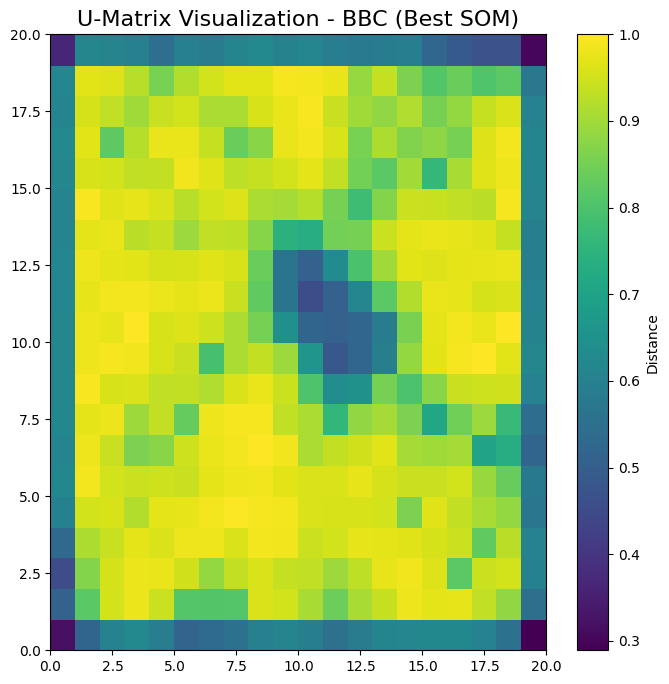

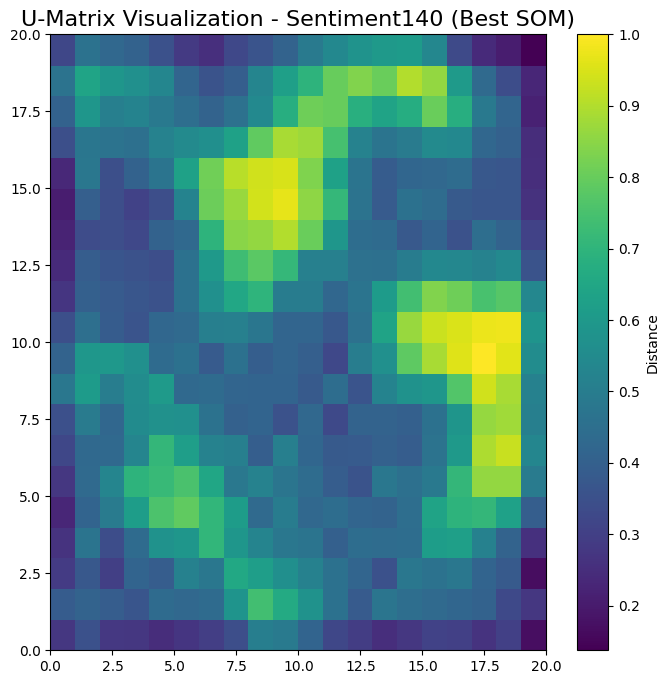

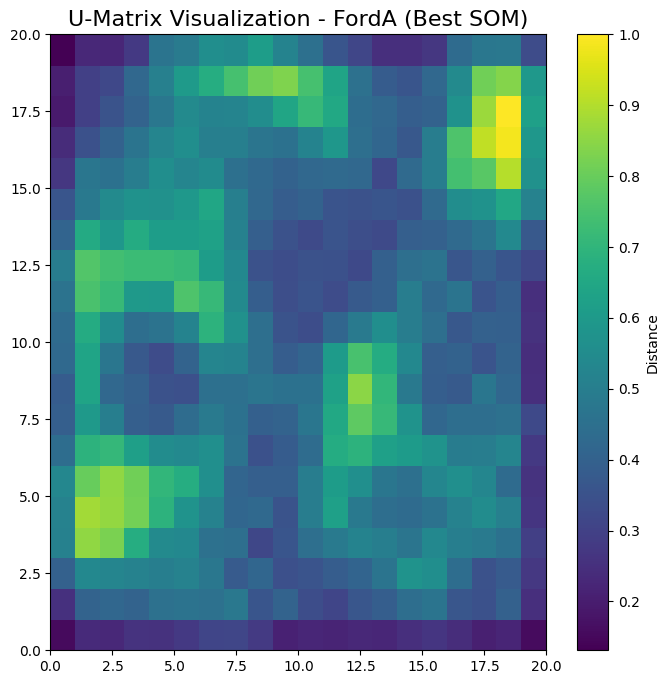

In [6]:
def plot_umatrix(som, title):
    """
    Visualisasi U-Matrix dari SOM
    """
    umatrix = som.distance_map().T  # transpose supaya orientasi benar
    plt.figure(figsize=(8, 8))
    plt.title(f"U-Matrix Visualization - {title}", fontsize=16)
    plt.pcolor(umatrix, cmap='viridis')  # pcolor untuk jarak antar neuron
    plt.colorbar(label='Distance')
    plt.show()

# Visualisasi SOM terbaik dari hasil tuning
plot_umatrix(som_bbc, "BBC (Best SOM)")
plot_umatrix(som_sent, "Sentiment140 (Best SOM)")
plot_umatrix(som_forda, "FordA (Best SOM)")


In [8]:
def count_active_neurons(som, data):
    """
    Menghitung jumlah neuron aktif (yang menjadi winner untuk minimal 1 data point)
    """
    winners = [som.winner(x) for x in data]
    unique_winners = set(winners)
    return len(unique_winners)

# Hitung cluster (neuron aktif) per dataset
bbc_clusters = count_active_neurons(som_bbc, X_bbc_tfidf)
sent_clusters = count_active_neurons(som_sent, X_sent_sampled)
forda_clusters = count_active_neurons(som_forda, X_forda_scaled)

# Tampilkan hasil
print("=== Estimated Number of Clusters (Activated Neurons) ===")
print(f"BBC           : {bbc_clusters} clusters")
print(f"Sentiment140  : {sent_clusters} clusters")
print(f"FordA         : {forda_clusters} clusters")

=== Estimated Number of Clusters (Activated Neurons) ===
BBC           : 380 clusters
Sentiment140  : 400 clusters
FordA         : 400 clusters


# Evaluasi Self-Organizing Map (SOM) pada Dataset BBC, Sentiment140, dan FordA

---

## Hasil Evaluasi

| Dataset         | Quantization Error (QE) | Topographic Error (TE)   |
|-----------------|--------------------------|---------------------------|
| **BBC**         | 0.7667                   | 0.9533                    |
| **Sentiment140**| 0.8655                   | 0.8044                    |
| **FordA**       | 2.5240                   | 0.8084                    |

---

## Apa itu QE dan TE?

- **Quantization Error (QE)**  
  Mengukur rata-rata jarak antara data asli dengan neuron pemenang pada SOM.  
  Nilai QE yang lebih rendah berarti representasi data yang lebih akurat.

- **Topographic Error (TE)**  
  Mengukur seberapa baik SOM menjaga struktur topologi data asli.  
  Nilai TE yang lebih rendah menandakan peta yang lebih rapi dan konsisten secara topologi.

---

## Interpretasi Hasil

- Dataset **BBC** memiliki QE terendah, yang berarti model SOM-nya paling akurat dalam merepresentasikan data.
- Dataset **Sentiment140** memiliki TE terendah, menunjukkan performa terbaik dalam menjaga struktur topologi data.
- Nilai TE pada semua dataset masih tergolong tinggi (>0.8), menandakan adanya ruang untuk perbaikan dalam pelestarian topologi.

---

## Dataset dengan Performa Terbaik

- **Quantization Error (QE) terbaik**: **BBC** (QE = 0.7667)  
- **Topographic Error (TE) terbaik**: **Sentiment140** (TE = 0.8044)

---

## Kesimpulan

- SOM memberikan representasi data yang cukup baik, terutama pada dataset **BBC** dari sisi akurasi.
- Untuk pemeliharaan topologi, dataset **Sentiment140** menunjukkan hasil yang lebih baik dibanding yang lain.


# **Tahap 6 – Analisis dan Diskusi**

Pada tahap ini dilakukan analisis dan diskusi terhadap hasil evaluasi dan visualisasi model SOM pada ketiga dataset. Pembahasan meliputi:

---

## **Analisis Kinerja SOM**

- Dataset **BBC** menunjukkan nilai **Quantization Error (QE)** terendah (**QE = 0.7667**), menandakan representasi data yang paling akurat oleh SOM.
- Dataset **Sentiment140** memiliki nilai **Topographic Error (TE)** terendah (**TE = 0.8044**), menunjukkan bahwa model paling baik dalam menjaga struktur topologi data.
- Meskipun begitu, nilai **TE pada semua dataset masih cukup tinggi (>0.8)**, sehingga pemetaan topologi belum optimal dan masih bisa ditingkatkan.

---

## **Faktor yang Mempengaruhi Hasil**

- **Kualitas preprocessing** seperti pembersihan teks, normalisasi, dan representasi fitur (TF-IDF, embeddings) sangat memengaruhi hasil klastering SOM.
- **Pemilihan dan tuning hyperparameter** seperti ukuran grid, nilai sigma, dan learning rate berperan besar dalam performa akhir model.
- **Karakteristik data**, apakah data teks (BBC, Sentiment140) atau time-series (FordA), memengaruhi tingkat kesulitan dalam menemukan pola klaster.

---

## **Kekuatan dan Keterbatasan SOM**

### Kekuatan:
- Mampu memvisualisasikan dan mengelompokkan data berdimensi tinggi secara **intuitif**.  
  > *Maksud dari “intuitif” di sini adalah hasil klaster dapat divisualisasikan dalam bentuk dua dimensi (misalnya sebagai peta berwarna atau grid), sehingga pola atau kelompok data yang mirip bisa langsung terlihat oleh mata manusia tanpa perlu analisis statistik yang rumit.*
- Dapat digunakan untuk eksplorasi data tanpa label (unsupervised learning) dan deteksi pola tersembunyi.

### Keterbatasan:
- Sensitif terhadap parameter dan skala data input.
- Pada data dengan struktur kompleks, SOM dapat kesulitan menjaga struktur topologi secara akurat.
- Proses tuning parameter dapat memakan waktu, terutama pada dataset yang besar.

---

> **Kesimpulan:**  
> Analisis ini menyoroti pentingnya **preprocessing yang baik**, **tuning parameter yang cermat**, dan **pemilihan metode yang sesuai dengan jenis data** agar hasil klastering menggunakan SOM menjadi optimal dan interpretatif.
